# Preparing medical X-ray images (DICOM) for Machine Learning

In [ ]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 12.7 MB/s 


In [ ]:
import os
import pandas as pd
import numpy as np
import pydicom
from google.colab import drive
import zipfile
import re
import cv2
import json 

## Download data

##### From Kaggle competition:
https://www.kaggle.com/competitions/unifesp-x-ray-body-part-classifier

##### Usually the DICOM data is stored in many subfolders, you can load them all together in the parent folder using Total Commander or a terminal query: 
`find /Users/tonyd/Desktop/xray/train/ -mindepth 2 -type f -exec mv -i '{}' /Users/tonyd/Desktop/xray/train/ ';'`

### Download images to Colab as zip (it's working faster) from Google Drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_file='/content/drive/My Drive/001.zip'
z=zipfile.ZipFile(zip_file,'r')
z.extractall()

### Download CSV file with file names and targets

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
train_df.head(3)

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10025629581362719970...,0
1,1.2.826.0.1.3680043.8.498.10036150326276641158...,15
2,1.2.826.0.1.3680043.8.498.10038426859954986240...,12


### Get filenames list

In [ ]:
file_names = list(train_df['SOPInstanceUID'])

### See DICOM image

In [ ]:
folder_path = r"/content/"
file_path = os.path.join(folder_path, file_names[1000] + '-c.dcm')
ds = pydicom.dcmread(file_path)

/usr/local/lib/python3.7/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:239: UserWarning: The (0028,0101) 'Bits Stored' value (15-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({bits_stored}-bit) "


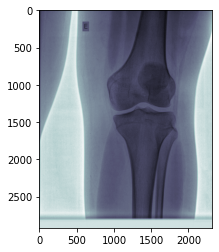

In [ ]:
from matplotlib import pyplot
pyplot.imshow(ds.pixel_array,cmap=pyplot.cm.bone)
pyplot.show()

### Create features (X) from images and targets (y) from file

In [ ]:
X_temp=[]
y_temp=[]

In [ ]:
for el in file_names:
  y_temp.append(train_df['Target'][train_df['SOPInstanceUID']==el].values) # find files target in DataFrame from CSV & add to'y'
  file_name = el + '-c.dcm'                                                # get filename with img
  file_path = os.path.join(folder_path,file_name)                          # get img adress
  ds = pydicom.dcmread(file_path)                                          # transform from DICOM
  data = np.array(ds.pixel_array)                                          # transform to numpy array
  image = cv2.resize(data, (84, 84))                                       # resize
  image=image/255                                                          # change grayscale to 256 format
  X_temp.append(image)                                                     # add features to 'X'


/usr/local/lib/python3.7/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:239: UserWarning: The (0028,0101) 'Bits Stored' value (15-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({bits_stored}-bit) "
/usr/local/lib/python3.7/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:239: UserWarning: The (0028,0101) 'Bits Stored' value (10-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({bits_stored}-bit) "
/usr/local/lib/python3.7/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:239: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({bits_stored}-bit) "


In [ ]:
train_df.groupby(['Target'])['Target'].count()

Target
0             80
0 15           1
0 3           11
1             41
1 11 12        5
1 12           1
1 6            7
10            19
10 11 19       2
10 19          4
11           102
11 12          1
12            19
13            39
13 20         45
14           120
15            67
15 19          2
16            40
17            23
18            10
19             7
2             77
2 13 20        3
2 20           1
20            15
21            63
3            724
3 15           1
3 6            1
3 7            1
4              9
5             23
5 8            2
6             70
7             15
7 9            1
8             12
8 16           1
9             31
9 21          42
Name: Target, dtype: int64

##### A lot of multiple values in target, encode such values into unique classes.

In [ ]:
y_no_proc=np.array(y_temp)
y_no_proc=y_no_proc.T

decoding_dict={}                                          # make a dictionary for two and more values class for decoding
y=[]                                                      
n=21                                                      # unique categories (from documentation) 

def get_key(d, value):                                    # the function to check the value class in a dictionary
    for k, v in d.items():
        if v == value:
            return k

              
for i in range(0,len(y_no_proc[0])):
    temp = y_no_proc[0][i].rstrip().split(' ')            # split a value by spaces to get list of values
    if len(temp)==1:
        y.append(int(temp[0]))                            # save a one-dimensional value to 'y'
    if len(temp)!=1:
        if temp not in decoding_dict.values():            # save a multidimensional value to dictionary
            n = n+1                                       # assign a class
            y.append(n)                                   # save a class to 'y'
            decoding_dict[n] = temp
        else:
            y.append(get_key(decoding_dict, temp))        # save a class to 'y' which was previously assigned

In [ ]:
X=np.array(X_temp)                                        # make a np.array 
X = X.reshape(X.shape[0], (X.shape[1] * X.shape[2]))      # reshape 3d array to 2d for sving to CSV file
X.shape

(1738, 7056)

In [ ]:
pd.DataFrame(X).to_csv("train_X.csv", header = False , index = False)              # save features (X)

In [ ]:
pd.DataFrame(y).to_csv("train_y.csv", header = False , index = False)              # save targets (y)

In [ ]:
decoding_dict

{22: ['13', '20'],
 23: ['9', '21'],
 24: ['0', '3'],
 25: ['1', '11', '12'],
 26: ['0', '15'],
 27: ['11', '12'],
 28: ['1', '6'],
 29: ['10', '19'],
 30: ['5', '8'],
 31: ['3', '15'],
 32: ['7', '9'],
 33: ['15', '19'],
 34: ['2', '13', '20'],
 35: ['3', '6'],
 36: ['2', '20'],
 37: ['10', '11', '19'],
 38: ['1', '12'],
 39: ['3', '7'],
 40: ['8', '16']}

In [ ]:
with open("codes.json", "w") as outfile:
    json.dump(decoding_dict, outfile)                                           # save dict for decoding